# Dataset Preparation


### Setup

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

## Data Collection


In [16]:
dataset_path = './regression-problems/szeged-weather/dataset/weatherHistory.csv'

df = pd.read_csv(dataset_path)

# The Dataset is too large, so we will only use the first 1000 rows

df = df.iloc[:1000]

# for convience, rename all the columns in snake case and remove special characters
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/', '_').str.replace('-', '_')

df.head()

,formatted_date,summary,precip_type,temperature_c,apparent_temperature_c,humidity,wind_speed_km_h,wind_bearing_degrees,visibility_km,loud_cover,pressure_millibars,daily_summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Handling missing values


In [17]:
from pandas.api.types import is_numeric_dtype



df = df.apply(lambda x: x.fillna(x.median()) if is_numeric_dtype(x) else x.fillna(x.mode()[0]))

df.isnull().sum()

formatted_date            0
summary                   0
precip_type               0
temperature_c             0
apparent_temperature_c    0
humidity                  0
wind_speed_km_h           0
wind_bearing_degrees      0
visibility_km             0
loud_cover                0
pressure_millibars        0
daily_summary             0
dtype: int64

## Encoding categorical features with One-Hot Encoding


In [18]:
# Dropping the datetime and summary columns as they are not required

df = df.drop(['formatted_date', 'daily_summary', 'summary', 'apparent_temperature_c'], axis=1)

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

categorical_features.remove('precip_type')

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

df.head()

,precip_type,temperature_c,humidity,wind_speed_km_h,wind_bearing_degrees,visibility_km,loud_cover,pressure_millibars
0,rain,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,rain,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,rain,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,rain,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,rain,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51


## Encoding binary class label


In [19]:
df.precip_type = df.precip_type.map(lambda x: 1 if x == 'rain' else -1)

df.head()

,precip_type,temperature_c,humidity,wind_speed_km_h,wind_bearing_degrees,visibility_km,loud_cover,pressure_millibars
0,1,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,1,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,1,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,1,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,1,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51


# Model Building


In [20]:
from sklearn.model_selection import *
from sklearn.tree import *
from sklearn.exceptions import *
from sklearn.metrics import *
from sklearn.ensemble import *  
from sklearn.linear_model import *

## Splitting the dataset into training and testing sets


In [21]:
target_column = 'temperature_c'

x = df.drop(target_column, axis=1)
y = df[target_column]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Evaluation function


In [22]:
def evaluate_regression(expected, predicted):
    print('Mean Absolute Error:', mean_absolute_error(expected, predicted))  
    print('Mean Squared Error:', mean_squared_error(expected, predicted))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(expected, predicted)))

## Model Building


In [50]:
model = RandomForestRegressor()

## Model Evaluation


### Cross Validation

In [52]:
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']
cross_validation_results = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

for metric, scores in cross_validation_results.items():
  if 'time' not in metric:
    name  = metric.replace('test_','' ).capitalize()
    print(f'{name}: {-np.mean(scores):.2f} += {np.std(scores):.2f}')
  


Neg_mean_absolute_error: 3.13 += 0.43
Neg_mean_squared_error: 16.72 += 4.24
Neg_root_mean_squared_error: 4.06 += 0.51


### Cross Validation with KFold

In [53]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']
cross_validation_results = cross_validate(model, x_train, y_train, cv=k_fold, scoring=scoring)

for metric, scores in cross_validation_results.items():
  if 'time' not in metric:
    name  = metric.replace('test_','' ).capitalize()
    print(f'{name}: {-np.mean(scores):.2f} += {np.std(scores):.2f}')
  


Neg_mean_absolute_error: 3.15 += 0.33
Neg_mean_squared_error: 16.85 += 3.37
Neg_root_mean_squared_error: 4.09 += 0.39


### Cross Validation with StratifiedKFold

## Model Building with Hyperparameter Tuning


In [55]:
model = RandomForestRegressor()
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}
grid_search = GridSearchCV(model, param_grid=params, cv=k_fold, scoring='neg_mean_absolute_error')

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

{'max_depth': 15, 'n_estimators': 50}



## Model Evaluation


Mean Absolute Error: 3.021326455009783
Mean Squared Error: 15.714487745751958
Root Mean Squared Error: 3.964150318258877


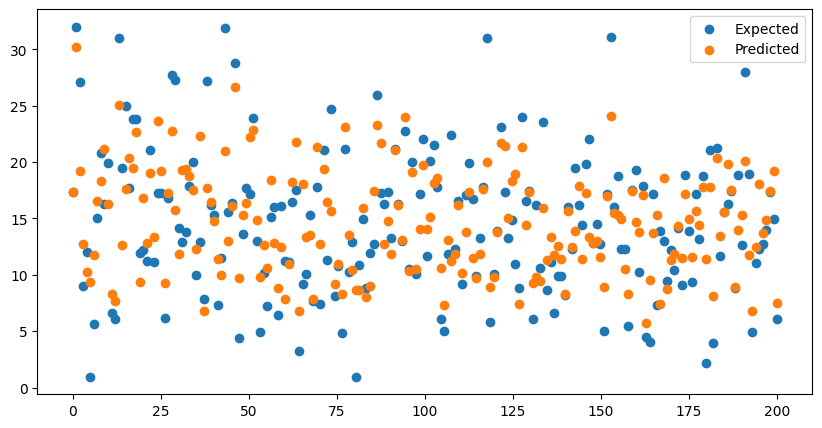

In [56]:
best_model = grid_search.best_estimator_

best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)

evaluate_regression(y_test, y_pred)



# plot the difference between the expected and predicted values
plt.figure(figsize=(10, 5))
plt.scatter(np.linspace(0, len(y_test), 200), y_test.values, label='Expected')
plt.scatter(np.linspace(0, len(y_test), 200), y_pred, label='Predicted')
plt.legend()
plt.show()

# Comparing Different Models Performance

## Model Building

In [57]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
}

## Model Comparison

In [58]:

results = {}
for name, model in models.items():
  results[name] = -cross_val_score(model, x_train, y_train, cv=k_fold, scoring='neg_mean_absolute_error')
  
results = pd.DataFrame(results).transpose()

results['mean'] = results.mean(axis=1)
results['std'] = results.std(axis=1)

results = results.sort_values('mean', ascending=True)

results

,0,1,2,3,4,5,6,7,8,9,mean,std
Random Forest,3.033103,3.167694,2.937494,2.807962,2.922384,3.346265,3.022883,2.926928,3.159799,4.071424,3.139594,0.343571
Gradient Boosting,3.151401,3.274090,3.611616,3.041906,3.332464,3.674087,3.223749,3.263612,3.489119,3.971540,3.403358,0.267303
Linear Regression,3.910160,3.769254,3.963217,3.847863,3.505397,4.343902,3.643516,3.760988,4.094601,4.778096,3.961699,0.351089
Decision Tree,4.130000,4.096181,3.573542,3.825000,4.409861,3.801250,3.767639,3.660347,4.093681,5.122083,4.047958,0.431316
